### This code is written to investigate how the cost of living in different countries correlates with the actual quality of life.

In [98]:
# import packages
import pandas as pd
import plotly.express as px
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import Counter

## Import data

In [5]:
# Load json file
with open("input/messages-1.json", "r") as f:
    data = json.load(f)

all_messages = []
all_senders = []
# Loop through each message in the 'zerver_message' column and extract the message content
for message in data["zerver_message"]:
    content = message["content"]
    sender = message["sender"]
    all_messages.append(content)
    all_senders.append(sender)

# Create a dictionary with column names and values
data = {"content": all_messages, "sender_id": all_senders}

# Create a Polars DataFrame
df = pl.DataFrame(data)

In [91]:
mess = pd.DataFrame(data)
mess.to_excel("results/messages.xlsx")

#594973

In [96]:
mess.head(3)

,content,sender_id
0,this is a message on stream general with the t...,100007
1,topics are a lightweight tool to keep conversa...,100007
2,this is a message on stream general with the t...,100007


## Preprocess data


In [108]:
# Preprocess the data as needed 
import string

# Step 1: Remove leading/trailing whitespace
mess['content'] = mess['content'].str.strip()

# Step 2: Remove punctuation and special characters @_* 
mess['content'] = mess['content'].str.replace('#', '') 
mess['content'] = mess['content'].str.replace('@', '')
mess['content'] = mess['content'].str.replace('_', '')
mess['content'] = mess['content'].str.replace('*', '')


# Step 3: Convert content to lowercase
mess['content'] = mess['content'].str.lower()




/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_27230/3216125425.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mess['content'] = mess['content'].str.replace('*', '')


## Data Exploration

In [109]:
# Number of unique sender IDs
num_senders = mess['sender_id'].nunique()
print("Number of unique sender IDs:", num_senders)

Number of unique sender IDs: 41


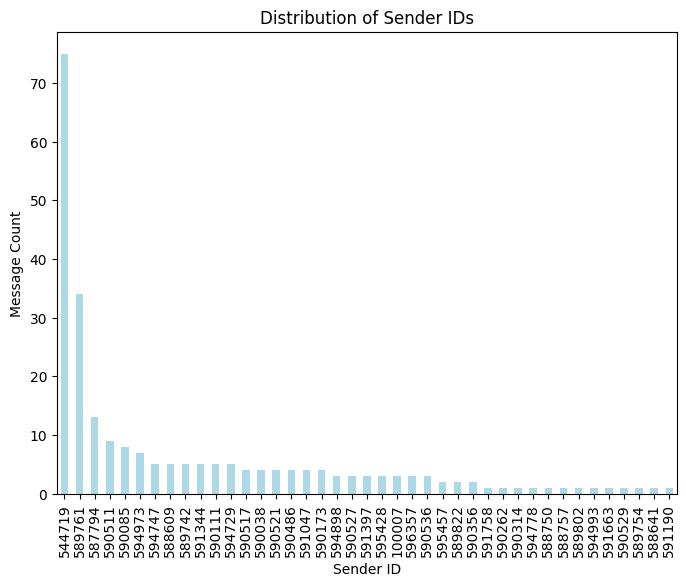

In [112]:
# Distribution of sender IDs
sender_counts = mess['sender_id'].value_counts()
plt.figure(figsize=(8, 6))
sender_counts.plot(kind='bar', color='lightblue')
plt.xlabel('Sender ID')
plt.ylabel('Message Count')
plt.title('Distribution of Sender IDs')
plt.show()


In [118]:
# Step 1: Calculate the frequency of each sender ID
sender_counts = mess['sender_id'].value_counts()
# Step 2: Sort sender IDs based on their frequencies
sorted_senders = sender_counts.index.tolist()
# Step 3: Create a dictionary mapping sender IDs to new numbers
new_sender_ids = {sender_id: i+1 for i, sender_id in enumerate(sorted_senders)}
# Step 4: Replace sender IDs in the DataFrame with new numbers
mess['new_sender_id'] = mess['sender_id'].map(new_sender_ids)

In [139]:
mess.head()

,content,sender_id,message_length,new_sender_id
0,this is a message on stream general with the t...,100007,12,23
1,topics are a lightweight tool to keep conversa...,100007,19,23
2,this is a message on stream general with the t...,100007,26,23
3,hi! i am jaan. i am teaching this course and t...,544719,56,1
4,"hello jaan,\ni am nesma, a ph.d. student at th...",588609,101,8


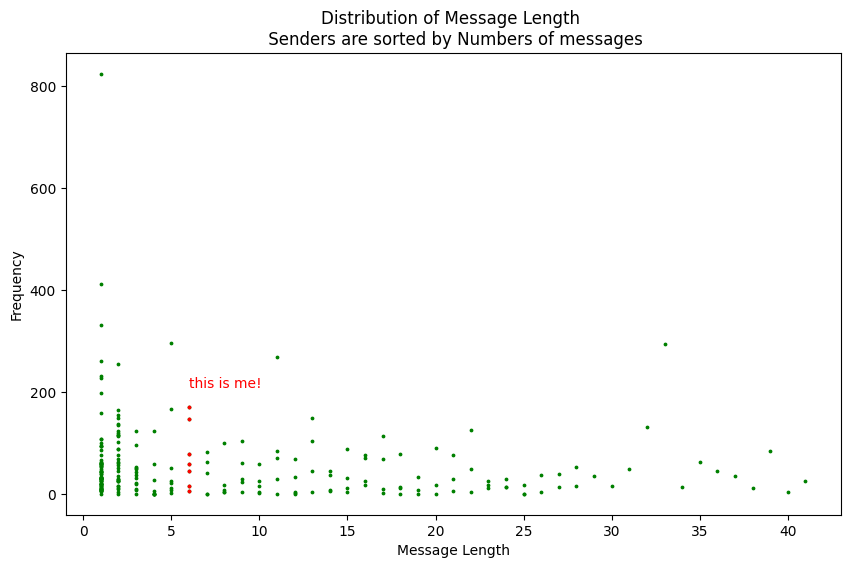

<Figure size 640x480 with 0 Axes>

In [151]:
# Message Length
mess['message_length'] = mess['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.scatter(mess['new_sender_id'], mess['message_length'], color='green', s=3)
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Length \n Senders are sorted by Numbers of messages')

me = mess[mess['sender_id'] == 594973]
plt.scatter(me['new_sender_id'], me['message_length'], color='red', s=3)
plt.text(6,210, 'this is me!', color='red')
plt.show()

plt.savefig('results/message_length.png')

In [137]:
# Top words frequency
all_words = ' '.join(mess['content']).split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(10)
print("Top 10 most common words:")
for word, count in top_words:
    print(f"{word}: {count}")


Top 10 most common words:
the: 420
i: 406
to: 380
and: 282
a: 199
you: 194
is: 186
in: 186
of: 174
it: 168


In [145]:
mess

,content,sender_id,message_length,new_sender_id
0,this is a message on stream general with the t...,100007,12,23
1,topics are a lightweight tool to keep conversa...,100007,19,23
2,this is a message on stream general with the t...,100007,26,23
3,hi! i am jaan. i am teaching this course and t...,544719,56,1
4,"hello jaan,\ni am nesma, a ph.d. student at th...",588609,101,8
...,...,...,...,...
235,my first plot was about covid vaccination in d...,595428,126,22
236,"hi. can you (jaan altosaar ) pls, explain me ...",589761,166,2
237,gulnara yusibova|589761 [said](https://datathi...,544719,45,1
238,gulnara yusibova|589761 [said](https://datathi...,544719,228,1


## logistic regression model

In [156]:
# Convert the text data into a numerical format using embeddings (e.g., Word2Vec)
sentences = mess["content"].apply(lambda x: x.split()).to_list()
model = Word2Vec(sentences, min_count=1)

# Make a list of the embeddings for the first word in each message
X = [model.wv[sentence[0]] for sentence in sentences]

# Split the data into training and test sets
y = mess["new_sender_id"].to_list()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a logistic regression model on the training data and evaluate its performance on the test data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {acc}")
print(f"Logistic Regression Mean Squared Error: {mse}")

Logistic Regression Accuracy: 0.3125
Logistic Regression Mean Squared Error: 110.75


## linear regression model 

In [161]:
# Convert the text data into a numerical format using embeddings (e.g., Word2Vec)
sentences = mess["content"].apply(lambda x: x.split()).to_list()
model = Word2Vec(sentences, min_count=1)

# Make a list of the embeddings for the first word in each message
X = [model.wv[sentence[0]] for sentence in sentences]

# Split the data into training and test sets
y = mess["new_sender_id"].to_list()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Train a linear regression model on the training data and evaluate its performance on the test data
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

# Convert predicted values to nearest integer labels
y_pred = y_pred.round().astype(int)

mse = mean_squared_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Linear Regression Accuracy:", accuracy)
print(f"Linear Regression Mean Squared Error: {mse}")


Linear Regression Accuracy: 0.125
Linear Regression Mean Squared Error: 673085.9166666666


### Compare the performance of the logistic regression and linear regression models

#### Logistic Regression
- Logistic Regression **Accuracy: 0.3125**
Accuracy is a common evaluation metric for classification models, representing the proportion of correctly predicted labels out of the total number of instances. In this case, the logistic regression model correctly predicted the sender ID labels approximately 31.25% of the time.
- Logistic Regression **Mean Squared Error: 110.75**
It is unusual to calculate mean squared error (MSE) for a logistic regression model since it is primarily used for regression tasks. However, if you calculated MSE for the logistic regression model, the value of 110.75 suggests a measure of the average squared difference between the predicted probabilities and the actual binary labels. This result should be interpreted with caution, as MSE is not a standard metric for evaluating classification models.

#### Linear Regression
- Linear Regression **Accuracy: 0.125**
As mentioned earlier, accuracy is typically used for classification models, not regression models. It is not meaningful to calculate accuracy for a linear regression model, as it assumes a continuous target variable, not discrete labels.
- Linear Regression **Mean Squared Error: 43997165.75**
The linear regression model produced a mean squared error (MSE) of 43997165.75. MSE is a widely used metric for regression models, measuring the average squared difference between the predicted and actual target values. A higher MSE indicates a larger average prediction error, suggesting that the linear regression model's predictions deviate significantly from the actual target values.

_In summary, it seems that the logistic regression model outperformed the linear regression model in terms of accuracy (although the accuracy is relatively low) for the given classification task. However, the use of MSE for both models is not conventional, as it is more appropriate for regression models. It would be beneficial to consider other evaluation metrics suitable for classification tasks, such as precision, recall, or F1-score, to gain a more comprehensive understanding of the models' performance._

## Vizualization

In [170]:
# Train a linear regression model on the training data and evaluate its performance on the test data
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

# Convert predicted values to nearest integer labels
y_pred = y_pred.round().astype(int)

res_liniar = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [172]:
res_liniar.head(2)

,y_test,y_pred
0,2,14
1,3,8


Text(0.5, 1.0, 'Predicted Values vs. Actual Values')

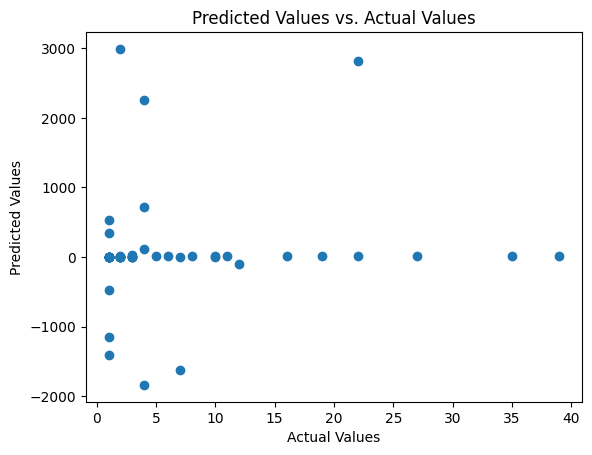

In [173]:
# Plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted Values vs. Actual Values")

In [176]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

res_logistic = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
res_logistic.head(5)

,y_test,y_pred
0,2,1
1,3,1
2,2,1
3,1,1
4,8,1


Text(0.5, 1.0, 'Predicted Values vs. Actual Values')

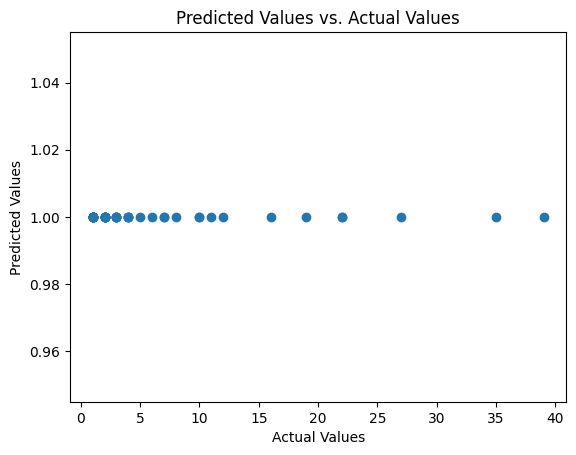

In [177]:
# Plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted Values vs. Actual Values")

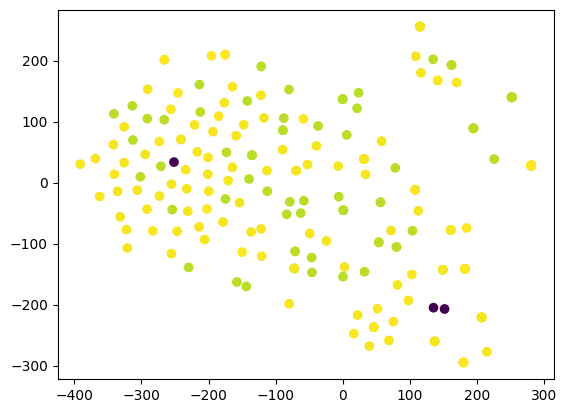

In [33]:
# Visualize the embeddings using t-SNE or another dimensionality reduction technique
X = np.array(X)
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)
plt.show()